## Imports and Functions

In [1]:
from tqdm import tqdm
from time import time
from multiprocessing import Pool
#from imblearn.over_sampling import KMeansSMOTE, SMOTE
from sklearn import preprocessing
import math, os
import numpy as np
from scipy import signal
import pandas as pd
import resampy
import io
import msoffcrypto
import glob
from xgboost import XGBClassifier
from collections import Counter
from sklearn.metrics import confusion_matrix
from datetime import datetime
from datetime import date
import random
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, confusion_matrix, precision_score
from sklearn.metrics import roc_auc_score
from scipy import stats as st
import seaborn as sns
import umap

In [2]:
##predefined filter coeffi}cients, as found by Jan Brond
A_coeff = np.array(
    [1, -4.1637, 7.5712,-7.9805, 5.385, -2.4636, 0.89238, 0.06361, -1.3481, 2.4734, -2.9257, 2.9298, -2.7816, 2.4777,
     -1.6847, 0.46483, 0.46565, -0.67312, 0.4162, -0.13832, 0.019852])
B_coeff = np.array(
    [0.049109, -0.12284, 0.14356, -0.11269, 0.053804, -0.02023, 0.0063778, 0.018513, -0.038154, 0.048727, -0.052577,
     0.047847, -0.046015, 0.036283, -0.012977, -0.0046262, 0.012835, -0.0093762, 0.0034485, -0.00080972, -0.00019623])

def pptrunc(data, max_value):
    '''
    Saturate a vector such that no element's absolute value exceeds max_abs_value.
    Current name: absolute_saturate().
      :param data: a vector of any dimension containing numerical data
      :param max_value: a float value of the absolute value to not exceed
      :return: the saturated vector
    '''
    outd = np.where(data > max_value, max_value, data)
    return np.where(outd < -max_value, -max_value, outd)

def trunc(data, min_value):
  
    '''
    Truncate a vector such that any value lower than min_value is set to 0.
    Current name zero_truncate().
    :param data: a vector of any dimension containing numerical data
    :param min_value: a float value the elements of data should not fall below
    :return: the truncated vector
    '''

    return np.where(data < min_value, 0, data)

def runsum(data, length, threshold):
    '''
    Compute the running sum of values in a vector exceeding some threshold within a range of indices.
    Divides the data into len(data)/length chunks and sums the values in excess of the threshold for each chunk.
    Current name run_sum().
    :param data: a 1D numerical vector to calculate the sum of
    :param len: the length of each chunk to compute a sum along, as a positive integer
    :param threshold: a numerical value used to find values exceeding some threshold
    :return: a vector of length len(data)/length containing the excess value sum for each chunk of data
    '''
    
    N = len(data)
    cnt = int(math.ceil(N/length))

    rs = np.zeros(cnt)

    for n in range(cnt):
        for p in range(length*n, length*(n+1)):
            if p<N and data[p]>=threshold:
                rs[n] = rs[n] + data[p] - threshold

    return rs

def counts(data, filesf, B=B_coeff, A=A_coeff):
    '''
    Get activity counts for a set of accelerometer observations.
    First resamples the data frequency to 30Hz, then applies a Butterworth filter to the signal, then filters by the
    coefficient matrices, saturates and truncates the result, and applies a running sum to get the final counts.
    Current name get_actigraph_counts()
    :param data: the vertical axis of accelerometer readings, as a vector
    :param filesf: the number of observations per second in the file
    :param a: coefficient matrix for filtering the signal, as found by Jan Brond
    :param b: coefficient matrix for filtering the signal, as found by Jan Brond
    :return: a vector containing the final counts
    '''
    
    deadband = 0.068
    sf = 30
    peakThreshold = 2.13
    adcResolution = 0.0164
    integN = 10
    gain = 0.965

    #if filesf>sf:
    data = resampy.resample(np.asarray(data), filesf, sf)

    B2, A2 = signal.butter(4, np.array([0.01, 7])/(sf/2), btype='bandpass')
    dataf = signal.filtfilt(B2, A2, data)

    B = B * gain

    #NB: no need for a loop here as we only have one axis in array
    fx8up = signal.lfilter(B, A, dataf)

    fx8 = pptrunc(fx8up[::3], peakThreshold) #downsampling is replaced by slicing with step parameter

    return runsum(np.floor(trunc(np.abs(fx8), deadband)/adcResolution), integN, 0)

def POI(sample):
    """
    Calculate the percentage of time spent immobile in a window
    """
    def calc_mob_per_min(countx, county, countz):
        mob_per_min = []
        for i in range(0, len(countx), 60):
            countx_1m = np.mean(countx[i:i+60])
            county_1m = np.mean(county[i:i+60])
            countz_1m = np.mean(countz[i:i+60])
            mob_per_min.append(np.mean([countx_1m, county_1m, countz_1m]))
        return mob_per_min

    def percentagem_of_immobility(mob_per_min):
        mob_per_min = np.asarray(mob_per_min)
        inactivity_counts = (mob_per_min <= 4).sum() 
        return inactivity_counts/len(mob_per_min)

    # calculate counts per axis
    c1_1s = counts(sample[0], 10)
    c2_1s = counts(sample[1], 10)
    c3_1s = counts(sample[2], 10)
    mob_per_min = calc_mob_per_min(c1_1s, c2_1s, c3_1s)
    POI = percentagem_of_immobility(mob_per_min)
    return POI
    
        

In [3]:
def magnitude(sample):
    mag_vector = []
    for s in sample:
        mag_vector.append(math.sqrt(sum([s[0]**2, s[1]**2, s[2]**2])))
    return mag_vector

def A(sample):
    feat = []
    for col in range(0,sample.shape[1]):
        average = np.average(sample[:, col])
        feat.append(average)

    return np.mean(feat)


def SD(sample):
    feat = []
    for col in range(0, sample.shape[1]):
        std = np.std(sample[:, col])
        feat.append(std)

    return np.mean(feat)


def AAD(sample):
    feat = []
    for col in range(0, sample.shape[1]):
        data = sample[col,:]
        add = np.mean(np.absolute(data - np.mean(data)))
        feat.append(add)

    return np.mean(feat)


def ARA(sample):
    #Average Resultant Acceleration[1]:
    # Average of the square roots of the sum of the values of each axis squared √(xi^2 + yi^2+ zi^2) over the ED
    feat = []
    sum_square = 0
    sample = np.power(sample, 2)
    for col in range(0, sample.shape[1]):
        sum_square = sum_square + sample[:, col]

    sample = np.sqrt(sum_square)
    average = np.average(sample)
    feat.append(average)
    return np.mean(feat)

def COR(sample):
    feat = []
    for axis_i in range(0, sample.shape[1]):
        for axis_j in range(axis_i+1, sample.shape[1]):
            cor = np.corrcoef(sample[:, axis_i], sample[:, axis_j])
            cor = 0 if np.isnan(cor) else cor[0][1]
            feat.append(cor)

    return np.mean(feat)


def mag_mean(sample):
    mag = magnitude(sample)
    ft_mean = np.mean(mag)
    return ft_mean

def mag_std(sample):
    mag = magnitude(sample)
    ft_std = np.std(mag)
    return ft_std


def feature_extraction(sample):
    """
    Derive three activity intensity cues: mean and standard deviation of activity intensity,
    and duration of immobility during assessment window to summarize the data.
    # Average - A,
    # Standard Deviation - SD,
    # Average Absolute Difference - AAD,
    # Average Resultant Acceleration - ARA(1),
    """
    features = []

    mag = magnitude(sample)
    features = np.mean(mag)
    features = np.hstack((features, np.std(mag)))
    features = np.hstack((features, A(sample)))
    features = np.hstack((features, SD(sample)))
    features = np.hstack((features, AAD(sample)))
    features = np.hstack((features, ARA(sample)))
    features = np.hstack((features, POI(np.transpose(sample, (1,0)))))

    return features

In [4]:
def set_patient_map():
    # create a map between the subject_deiden_id and the patient id
    patient_map = {}
    patient_enrollment = pd.read_excel('/data/daily_data/patient_id_mapping.xlsx', engine='openpyxl')

    for row in patient_enrollment.itertuples():
        patient_map[row.patient_id] = row.subject_deiden_id

    return patient_map

In [5]:
def get_demo_data(X, y, y_target):
    passwd = 'pervasiveICU'

    filename = '/home/jsenadesouza/DA-healthy2patient/Pervasive_Sensing_Enrollment_Log.xlsx'
    decrypted_workbook = io.BytesIO()
    with open(filename, 'rb') as file:
        office_file = msoffcrypto.OfficeFile(file)
        office_file.load_key(password=passwd)
        office_file.decrypt(decrypted_workbook)

    ADAPT_enrollment = pd.read_excel(decrypted_workbook, engine="openpyxl")

    input_dir = '/data/datasets/ICU_Data/EHR_Data/truncated/2020-02-26/'
    df_2016 = pd.read_csv(os.path.join(input_dir, 'encounters_0_trimmed.csv'))

    df_2021 = []
    files_enc = glob.glob('/data/daily_data/*/encounters*.csv',
                          recursive=True)
    files_peso = glob.glob('/data/daily_data/*/height_weight*.csv',
                          recursive=True)

    for file in files_enc:
        df = pd.read_csv(file)
        df_2021.append(df)

    df_2021_peso = []
    for file in files_peso:
        df = pd.read_csv(file)
        df_2021_peso.append(df)


    df_2021 = pd.concat(df_2021)
    df_2021_peso = pd.concat(df_2021_peso)

    patients_char = []
    patient_map = set_patient_map()
    for patient_id in y_target:
        if "P" in patient_id or "I" in patient_id:
            row = df_2021[df_2021['patient_deiden_id'] == patient_map[patient_id]]
            height = np.mean(df_2021_peso[(df_2021_peso['patient_deiden_id'] == patient_map[patient_id]) & (df_2021_peso['measurement_name'] == 'weight_kgs')]['measurement_value'].values)
            weight = df_2021_peso[(df_2021_peso['patient_deiden_id'] == patient_map[patient_id]) & (df_2021_peso['measurement_name'] == 'height_cm')]['measurement_value'].values[0]
            if "I" in patient_id:
                try:
                    admit = datetime.strptime(ADAPT_enrollment['ICU_admit'][ADAPT_enrollment["Record ID"] == patient_id].values[0], '%m/%d/%y %H%M')
                except:
                    try:
                        admit = datetime.strptime(ADAPT_enrollment['ICU_admit'][ADAPT_enrollment["Record ID"] == patient_id].values[0], '%m/%d/%Y %H%M')
                    except:
                        print(f"admit: {ADAPT_enrollment['ICU_admit'][ADAPT_enrollment['Record ID'] == patient_id].values}")
                try:
                    consent = pd.Timestamp(ADAPT_enrollment['Consent Date'][ADAPT_enrollment["Record ID"] == patient_id].values[0])
                except:
                    print(f"consent: {ADAPT_enrollment['Consent Date'][ADAPT_enrollment['Record ID'] == patient_id].values}")
                try:
                    dischg = datetime.strptime(ADAPT_enrollment['ICU_dischg'][ADAPT_enrollment["Record ID"] == patient_id].values[0], '%m/%d/%y %H%M')
                except:
                    d_time = ADAPT_enrollment['ICU_dischg'][ADAPT_enrollment["Record ID"] == patient_id].values[0]
                    if type(d_time) == type(datetime):
                        dischg = d_time
                    else:              
                        dischg = datetime.combine(date.today(), datetime.min.time())
            else:
                ad_rows = row['admit_datetime'][~row['admit_datetime'].isna()].values
                dc_rows = row['dischg_datetime'][~row['dischg_datetime'].isna()].values
                try:
                    admit = datetime.strptime(min(ad_rows), '%Y-%m-%d %H:%M:%S')
                except:
                    admit = datetime.strptime(min(ad_rows), '%Y-%m-%d')
                try:
                    dischg = datetime.strptime(max(dc_rows), '%Y-%m-%d %H:%M:%S')
                except:
                    try:
                        dischg = datetime.strptime(max(dc_rows), '%Y-%m-%d')
                    except:
                        print(patient_id)
                        print(dc_rows)
                        dischg = datetime.combine(date.today(), datetime.min.time())
            consent = admit
        else:
            row = df_2016[df_2016['record_id'] == int(patient_id)]
            height = row['height_cm'][~row['height_cm'].isna()].values[0]
            weight = row['weight_kgs'][~row['weight_kgs'].isna()].values[0]
            ad_rows = row['admit_datetime'][~row['admit_datetime'].isna()].values
            dc_rows = row['dischg_datetime'][~row['dischg_datetime'].isna()].values
            try:
                admit = datetime.strptime(min(ad_rows), '%Y-%m-%d %H:%M:%S')
            except:
                admit = datetime.strptime(min(ad_rows), '%Y-%m-%d')
            try:
                dischg = datetime.strptime(max(dc_rows), '%Y-%m-%d %H:%M:%S')
            except:
                try:
                    dischg = datetime.strptime(max(dc_rows), '%Y-%m-%d')
                except:
                    print(patient_id)
                    print(dc_rows)
                    dischg = datetime.combine(date.today(), datetime.min.time())
            consent = admit


        birth = datetime.strptime(row['birth_date'][~row['birth_date'].isna()].values[0], '%Y-%m-%d')
        age = int((consent - birth).days/365)
        lenght_stay = abs((dischg - admit).days)

        gender = row['sex'][~row['sex'].isna()].values[0]
        race = row['race'][~row['race'].isna()].values[0]
        ethnicity = row['ethnicity'][~row['ethnicity'].isna()].values[0]
        if len(row['aids'][~row['aids'].isna()]) > 0:
            aids = row['aids'][~row['aids'].isna()].values[0]
        else:
            aids = -1
        if len(row['cancer'][~row['cancer'].isna()]) > 0:
            cancer = row['cancer'][~row['cancer'].isna()].values[0]
        else:
            cancer = -1
        if len(row['cerebrovascular_disease'][~row['cerebrovascular_disease'].isna()]) > 0:
            cerebrovascular_disease = row['cerebrovascular_disease'][~row['cerebrovascular_disease'].isna()].values[0]
        else:
            cerebrovascular_disease = -1
        if len(row['dementia'][~row['dementia'].isna()]) > 0:
            dementia = row['dementia'][~row['dementia'].isna()].values[0]
        else:
            dementia = -1
        if len(row['paraplegia_hemiplegia'][~row['paraplegia_hemiplegia'].isna()]) > 0:
            paraplegia_hemiplegia = row['paraplegia_hemiplegia'][~row['paraplegia_hemiplegia'].isna()].values[0]
        else:
            paraplegia_hemiplegia = -1
        if len(row['smoking_status'][~row['smoking_status'].isna()]) > 0:
            smoking_status = row['smoking_status'][~row['smoking_status'].isna()].values[0]
        else:
            smoking_status = -1
        if len(row['chf'][~row['chf'].isna()]) > 0:
            chf = row['chf'][~row['chf'].isna()].values[0]
        else:
            chf = -1
        if len(row['copd'][~row['copd'].isna()]) > 0:
            copd = row['copd'][~row['copd'].isna()].values[0]
        else:
            copd = -1

        if len(row['diabetes_w_o_complications'][~row['diabetes_w_o_complications'].isna()]) > 0:
            diabetes_w_o_complications = row['diabetes_w_o_complications'][~row['diabetes_w_o_complications'].isna()].values[0]
        else:
            diabetes_w_o_complications = -1    
        if len(row['diabetes_w_complications'][~row['diabetes_w_complications'].isna()]) > 0:
            diabetes_w_complications = row['diabetes_w_complications'][~row['diabetes_w_complications'].isna()].values[0]
        else:
            diabetes_w_complications = -1    
        if diabetes_w_o_complications == 1 or diabetes_w_complications == 1:
            diabetes = 1
        elif diabetes_w_o_complications == -1 and diabetes_w_complications == -1:
            diabetes = -1
        elif diabetes_w_o_complications == 0 and diabetes_w_complications == 0:
            diabetes = 0
        if len(row['m_i'][~row['m_i'].isna()]) > 0:
            m_i = row['m_i'][~row['m_i'].isna()].values[0]
        else:
            m_i = -1
        if len(row['metastatic_carcinoma'][~row['metastatic_carcinoma'].isna()]) > 0:
            metastatic_carcinoma = row['metastatic_carcinoma'][~row['metastatic_carcinoma'].isna()].values[0]
        else:
            metastatic_carcinoma = -1
        if len(row['mild_liver_disease'][~row['mild_liver_disease'].isna()]) > 0:
            mild_liver_disease = row['mild_liver_disease'][~row['mild_liver_disease'].isna()].values[0]
        else:
            mild_liver_disease = -1
        if len(row['moderate_severe_liver_disease'][~row['moderate_severe_liver_disease'].isna()]) > 0:
            moderate_severe_liver_disease = row['moderate_severe_liver_disease'][~row['moderate_severe_liver_disease'].isna()].values[0]
        else:
            moderate_severe_liver_disease = -1
        if mild_liver_disease == 1 or moderate_severe_liver_disease == 1:
            liver_disease = 1
        elif mild_liver_disease == -1 and moderate_severe_liver_disease == -1:
            liver_disease = -1
        elif mild_liver_disease == 0 and moderate_severe_liver_disease == 0:
            liver_disease = 0
        if len(row['peptic_ulcer_disease'][~row['peptic_ulcer_disease'].isna()]) > 0:
            peptic_ulcer_disease = row['peptic_ulcer_disease'][~row['peptic_ulcer_disease'].isna()].values[0]
        else:
            peptic_ulcer_disease = -1
        if len(row['peripheral_vascular_disease'][~row['peripheral_vascular_disease'].isna()]) > 0:
            peripheral_vascular_disease = row['peripheral_vascular_disease'][~row['peripheral_vascular_disease'].isna()].values[0]
        else:
            peripheral_vascular_disease = -1
        if len(row['renal_disease'][~row['renal_disease'].isna()]) > 0:
            renal_disease = row['renal_disease'][~row['renal_disease'].isna()].values[0]
        else:
            renal_disease = -1
        if len(row['rheumatologic_disease'][~row['rheumatologic_disease'].isna()]) > 0:
            rheumatologic_disease = row['rheumatologic_disease'][~row['rheumatologic_disease'].isna()].values[0]
        else:
            rheumatologic_disease = -1


        patients_char.append({'patient_id': patient_id, 'sex': gender, 'race': race, 'height_cm': height, 
                              'age':age, 'weight_kgs':weight, 'lenght_stay':lenght_stay, 
                              "ethnicity":ethnicity, "aids":aids, "cancer":cancer, "cerebrovascular_disease":cerebrovascular_disease,
                              "dementia":dementia, "paraplegia_hemiplegia":paraplegia_hemiplegia, "smoking_status":smoking_status,
                              "chf":chf, "copd":copd, "diabetes":diabetes, "m_i":m_i, "metastatic_carcinoma":metastatic_carcinoma, 
                              "liver_disease":liver_disease, "peptic_ulcer_disease":peptic_ulcer_disease, "renal_disease":renal_disease, 
                              "rheumatologic_disease":rheumatologic_disease
                             })



    df_char = pd.DataFrame(data=patients_char)

    df_char.loc[df_char.sex == 'MALE', 'sex']= 0
    df_char.loc[df_char.sex != 'MALE', 'sex']= 1
    df_char.loc[df_char.race == 'BLACK', 'race']= 0
    df_char.loc[df_char.race != 'BLACK', 'race']= 1
    df_char.loc[df_char.ethnicity == 'HISPANIC', 'ethnicity']= 0
    df_char.loc[df_char.ethnicity != 'HISPANIC', 'ethnicity']= 1
    df_char.loc[df_char.smoking_status == 'Former Smoker', 'smoking_status']= 0
    df_char.loc[df_char.smoking_status == 'Smoker', 'smoking_status']= 1
    df_char.loc[df_char.smoking_status == 'Smoker, Current Status Unknown', 'smoking_status']= 1
    df_char.loc[df_char.smoking_status == 'Current Every Day Smoker', 'smoking_status']= 1
    df_char.loc[df_char.smoking_status == 'Current Some Day Smoker', 'smoking_status']= 1
    df_char.loc[df_char.smoking_status == 'Light Tobacco Smoker', 'smoking_status']= 1
    df_char.loc[df_char.smoking_status == 'Never Smoker', 'smoking_status']= 2
    df_char.loc[df_char.smoking_status == 'Never Smoker ', 'smoking_status']= 2
    df_char.loc[df_char.smoking_status == 'Status Unknown', 'smoking_status']= 3
    df_char.loc[df_char.smoking_status == 'Unknown If Ever Smoked', 'smoking_status']= 3
    df_char.loc[df_char.smoking_status == 'Current Status Unknown', 'smoking_status']= 3
    df_char.loc[df_char.smoking_status == 'Unknown If Ever Smoked', 'smoking_status']= 3
    df_char.loc[df_char.smoking_status == 'Never Assessed', 'smoking_status']= 3
    

    X_char = []
    col_patient = y_col_names.index('patient_id')
    for xx, sample in zip(X.squeeze(), y):
        try:
            char_pat = df_char[df_char["patient_id"] == sample[col_patient]]
            char_final = list(char_pat.loc[:, char_pat.columns != "patient_id"].values[0])
            X_char.append(char_final)
        except:
            print(sample[col_patient])
    X_char = np.array(X_char)
    return X_char, df_char

In [6]:
def print_metrics(n_classes, cum_acc, cum_recall, cum_precision, cum_auc, cum_f1, cum_recall_macro, cum_precision_macro,
                  cum_f1_macro):
    current_acc = np.array(cum_acc)
    current_auc = np.array(cum_auc)
    current_recall_macro = np.array(cum_recall_macro)
    current_prec_macro = np.array(cum_precision_macro)
    current_f1_macro = np.array(cum_f1_macro)

    ci_mean = st.t.interval(0.95, len(current_acc) - 1, loc=np.mean(current_acc), scale=st.sem(current_acc))
    ci_auc = st.t.interval(0.95, len(current_auc) - 1, loc=np.mean(current_auc), scale=st.sem(current_auc))
    ci_recall_macro = st.t.interval(0.95, len(current_recall_macro) - 1, loc=np.mean(current_recall_macro),
                                    scale=st.sem(current_recall_macro))
    ci_prec_macro = st.t.interval(0.95, len(current_prec_macro) - 1, loc=np.mean(current_prec_macro),
                                  scale=st.sem(current_prec_macro))
    ci_f1_macro = st.t.interval(0.95, len(current_f1_macro) - 1, loc=np.mean(current_f1_macro),
                                scale=st.sem(current_f1_macro))

    print('accuracy: {:.2f} ± {:.2f}\n'.format(np.mean(current_acc) * 100,
                                                          abs(np.mean(current_acc) - ci_mean[0]) * 100))

    print('recall_macro: {:.2f} ± {:.2f}\n'.format(np.mean(current_recall_macro) * 100,
                                                              abs(np.mean(current_recall_macro) - ci_recall_macro[
                                                                  0]) * 100))
    print('precision_macro: {:.2f} ± {:.2f}\n'.format(np.mean(current_prec_macro) * 100,
                                                                 abs(np.mean(current_prec_macro) - ci_prec_macro[
                                                                     0]) * 100))
    print('f1-score_macro: {:.2f} ± {:.2f}\n'.format(np.mean(current_f1_macro) * 100,
                                                                abs(np.mean(current_f1_macro) - ci_f1_macro[
                                                                    0]) * 100))
    print('roc_auc: {:.2f} ± {:.2f}\n'.format(np.mean(current_auc) * 100,
                                                         abs(np.mean(current_auc) - ci_auc[0]) * 100))

    for class_ in range(n_classes):
        print(f"Class: {class_}")

        current_f1 = np.array(cum_f1)[:, class_]
        current_recall = np.array(cum_recall)[:, class_]
        current_prec = np.array(cum_precision)[:, class_]

        ci_f1 = st.t.interval(0.95, len(current_f1) - 1, loc=np.mean(current_f1), scale=st.sem(current_f1))
        ci_recall = st.t.interval(0.95, len(current_recall) - 1, loc=np.mean(current_recall),
                                  scale=st.sem(current_recall))
        ci_prec = st.t.interval(0.95, len(current_prec) - 1, loc=np.mean(current_prec), scale=st.sem(current_prec))

        print('recall: {:.2f} ± {:.2f}\n'.format(np.mean(current_recall) * 100,
                                                            abs(np.mean(current_recall) - ci_recall[0]) * 100))
        print('precision: {:.2f} ± {:.2f}\n'.format(np.mean(current_prec) * 100,
                                                               abs(np.mean(current_prec) - ci_prec[0]) * 100))
        print('f1-score: {:.2f} ± {:.2f}\n'.format(np.mean(current_f1) * 100,
                                                         abs(np.mean(current_f1) - ci_f1[0]) * 100))

In [7]:
def get_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1-score': f1_score(y_true, y_pred, average=None, labels=[0,1]),
        'f1-score_macro': f1_score(y_true, y_pred, average="macro", labels=[0, 1]),
        'recall': recall_score(y_true, y_pred, average=None, zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average="macro", zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'confusion_matrix_norm_true': confusion_matrix(y_true, y_pred, normalize='true'),
        'precision': precision_score(y_true, y_pred, average=None, zero_division=0),
        'precision_macro': precision_score(y_true, y_pred, average="macro", zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred, average="macro")
    }

In [8]:
def clean(X, y, col_target):
    if '-1' in np.unique(y[:, col_target]):
        idxs = np.argwhere(np.array(y[:, col_target]) != '-1')
        X = X[idxs]
        y = y[idxs]
    return np.squeeze(X), np.squeeze(y)

In [9]:
def split_data(X, y, y_target, labels2idx, patient_splits, folder_idx, logger=None):
    # split samples based on patients k-fold cross validation
    test_index, train_index = [], []
    for patient in patient_splits[folder_idx]:
        test_index.extend(list(np.where(y[:, -1] == patient)[0]))
    train_index = np.setdiff1d(np.arange(y.shape[0]), test_index)

    train_data, train_labels = X[train_index].squeeze(), y_target[train_index].squeeze()
    test_data, test_labels = X[test_index].squeeze(), y_target[test_index].squeeze()

    train_labels = np.array([labels2idx[label] for label in train_labels])
    test_labels = np.array([labels2idx[label] for label in test_labels])


    print(f"Folder {folder_idx + 1}")
    print(f"Train data: {get_class_distribution(np.unique(train_labels, return_counts=True))}")
    print(f"Test data: {get_class_distribution(np.unique(test_labels, return_counts=True))}")

    return train_data, train_labels, test_data, test_labels

In [10]:
def Find_Optimal_Cutoff(target, predicted):  # Youden index
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    Returns
    -------
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf': pd.Series(tpr - (1 - fpr), index=i), 'threshold': pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]


    return list(roc_t['threshold'])

In [11]:
def get_class_distribution(class_info):
    names, quant = class_info
    str = ""
    for name, q in zip(names, quant):
        str += f"{name}: {q/sum(quant)*100:.2f}% "
    return str

In [12]:
def split_patients(y, y_target):
    df_pat = pd.DataFrame(np.concatenate([np.expand_dims(y[:, -1], axis=1), np.expand_dims(y_target, axis=1)], axis=1), columns=["patients", "target"])

    patients_mild, patients_severe = {}, {}
    for pat in np.unique(df_pat.patients):
        names, counts = np.unique(df_pat["target"][df_pat["patients"] == pat].values, return_counts=True)
        if len(names)>1:
            print(f"{pat}: {names[0]}:{counts[0]}, {names[1]}:{counts[1]}")
        else:
            print(f"{pat}: {names[0]}:{counts[0]}")
            if int(names[0]) == 0:
                patients_mild[f"{pat}"] = counts[0]
            else:
                patients_severe[f"{pat}"] = counts[0]

    patients_mild = {k: v for k, v in sorted(patients_mild.items(), key=lambda item: item[1], reverse=True)}
    patients_severe = {k: v for k, v in sorted(patients_severe.items(), key=lambda item: item[1], reverse=True)}

    count_m = [45,113,26,0,0]
    count_s = [39,92,40,0,0]
    fold_m = [['I052A'],['P023'],['P038'],[],[]]
    fold_s = [['I052A'],['P023'],['P038'],[],[]]

    for k, v in patients_mild.items():
        min_idx = np.argmin(count_m)
        print(count_m)
        print(min_idx)
        count_m[min_idx] += v
        fold_m[min_idx].append(k)

    for k, v in patients_severe.items():
        min_idx = np.argmin(count_s)
        print(count_s)
        print(min_idx)
        count_s[min_idx] += v
        fold_s[min_idx].append(k)

    for i in range(5):
        print(fold_m[i])
        print(fold_s[i])
        print("\n")

    print(count_m)
    print(count_s)

## Read data and balance dataset

In [13]:
data_input_file = "/home/jsenadesouza/DA-healthy2patient/results/outcomes/dataset/t900_INTELLIGENT_ADAPT_PAIN_15wd_15drop_painprev.npz"
tmp = np.load(data_input_file, allow_pickle=True)
X = tmp["X"]
y = tmp['y']
y_col_names = list(tmp['y_col_names'])

col_idx_target = y_col_names.index("pain_score")
col_idx_prevpain = y_col_names.index('pain_score_prev')
X, y = clean(X, y, col_idx_target)

In [14]:
print("Extracting Features")
start = time()
with Pool(100) as p:
        X_feat = p.map(feature_extraction, X)
end = time()
print(f"{end-start:.4} seconds passed.")

X_feat = np.array(X_feat)

Extracting Features
269.7 seconds passed.


In [15]:
y_target = np.round(np.array(y[:, col_idx_target], dtype=float))
prev_pain = np.round(np.array(y[:, col_idx_prevpain], dtype=float))

#No pain vs Pain
print(np.unique(y_target, return_counts=True))
prev_pain_t = np.array([0 if x == 0 else 1 for x in prev_pain])
yy_t = np.array([0 if x == 0 else 1 for x in y_target])

folds_pat = []
folds_pat.append(['P023', 'P013', 'I051A', '49', '48', '100', 'I045A', 'P051', 'I028A', '112', '92', '83', 'P037', '22', '29', '35', '64', '58','P046', 'I001A', 'I034A'])
folds_pat.append(['I021A', 'I043A', 'I019A', 'I044A', 'I008A', '51', '106', 'P004', 'P007', '82', '69', 'P054', 'P055', '63', '41', '4', '89', 'I027A', 'P024', '17'])
folds_pat.append(['P038','P021', 'P017', 'P067', 'I033A', 'I050A', 'P052', '40', 'P015', '109', '90', 'I049A', '103', '14', '81', '60', '20', 'I047A', 'P006', '32'])
folds_pat.append(['I052A', '98', 'P029', 'I006A', 'I037A', 'P057', 'I004A', 'P042', 'I018A', 'P028', '25', 'P003', 'I025A', '39', '52', '28', '18', 'I053A', 'I023A', '8'])
folds_pat.append(['P010', 'I026A', '95', 'I042A', 'P063', '88', '66', '50', '93', '87', '65', '44', 'I022A', 'P070', '47', '26', '75', 'P009', '13', '15'])

folds_idx = [[],[],[],[],[]]
for i in range(5):
   for pat in folds_pat[i]:
       idxs = np.where(y[:, -1] == pat)[0]
       if len(idxs) > 0:
           folds_idx[i].extend(list(idxs))      
      
# idx = np.where(y_target != 0)
# print(np.unique(y_target[idx], return_counts=True))
# prev_pain_t = np.array([0 if x <= 5 else 1 for x in prev_pain[idx]])
# yy_t = np.array([0 if x <= 5 else 1 for x in y_target[idx]])
# X_feat = X_feat[idx]
# y = y[idx]

# folds_pat = []
# folds_pat.append(
#     ['I052A', 'P003', 'P007', 'P055', 'I008A', 'I026A', 'I052A', '32', 'P024', 'P010'])
# folds_pat.append(
#     ['P023', 'P015', 'I021A', 'P037', 'I018A', 'P017', 'P023', '13', 'P006', 'P009', 'I047A'])
# folds_pat.append(
#     ['P038', '17', 'P057', 'P054', 'I019A', 'P038', 'I034A', 'I023A', 'I001A', 'I027A'])
# folds_pat.append(
#     ['18', '15'])
# folds_pat.append(
#     ['28', 'I050A', 'I053A', '8', 'P046'])
# folds_idx = [[],[],[],[],[]]
# for i in range(5):
#     for pat in folds_pat[i]:
#         idxs = np.where(y[:, -1] == pat)[0]
#         if len(idxs) > 0:
#             folds_idx[i].extend(list(idxs))      

(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), array([8734,  372,  585,  649,  350,  769,  347,   58,  474,  285]))


In [16]:
print(np.unique(prev_pain_t, return_counts=True))
print(np.unique(yy_t, return_counts=True))

(array([0, 1]), array([8797, 3826]))
(array([0, 1]), array([8734, 3889]))


In [17]:
#X_demo, df_demo = get_demo_data(X, y, y[:, -1])
#np.savez_compressed('/home/jsenadesouza/DA-healthy2patient/results/outcomes/dataset/X_demo.npz', X_demo=X_demo)

In [18]:
#X_demo = np.load('/home/jsenadesouza/DA-healthy2patient/results/outcomes/dataset/X_demo.npz', allow_pickle=True)['X_demo']

## Extract features

In [19]:
folders = [[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]]
for i in range(len(folds_idx)):
    #print(f"Folder {i}")
    for j in range(len(folds_idx)):
        if i == j:
            #print(f"Train:{j}")
            folders[i][0].append(folds_idx[j])
        else:
            #print(f"Test:{j}")
            folders[i][1].extend(folds_idx[j])

In [20]:
#X_demo = X_demo.astype(float)

In [21]:
yy_t.shape

(12623,)

## Classification with XGboost class weight

In [22]:
import shap
cum_acc, cum_recall, cum_precision, cum_auc, cum_f1 = [], [], [], [], []
cum_recall_macro, cum_precision_macro, cum_f1_macro = [], [], []

X_data = np.concatenate([X_feat, np.expand_dims(prev_pain_t, axis=1)], axis=1)
#X_data = np.concatenate([X_demo[:, :7], np.expand_dims(prev_pain_t, axis=1)], axis=1)
#X_data = np.concatenate([np.expand_dims(prev_pain_t, axis=1), np.expand_dims(prev_pain_t, axis=1)], axis=1)
#X_data=X_demo
#X_data=X_feat
num_folders=5
n_classes=2
seed = 1
random.seed(seed)
labels2idx = {k: idx for idx, k in enumerate(np.unique(y_target))}
for folder_idx in range(num_folders):
    # writer = SummaryWriter(
    #     f'/home/jsenadesouza/DA-healthy2patient/results/outcomes/tensorboard/transformers/exp_name/run_{time()}')

    # split the data into train, val and test sets
    train_idx = folders[folder_idx][0]
    test_idx = folders[folder_idx][1]
    train_data, train_labels, test_data, test_labels = X_data[train_idx], yy_t[train_idx], X_data[test_idx], yy_t[test_idx]
    counter = Counter(train_labels)
    # estimate scale_pos_weight value
    estimate = counter[0] / counter[1]
    print(f'Estimate: {estimate}. {counter}')
    # fit model no training data
    #model = XGBClassifier(tree_method="gpu_hist", use_label_encoder=False, eval_metric='logloss',
    #                      scale_pos_weight=estimate, random_state=42)
    model = XGBClassifier(scale_pos_weight=estimate, random_state=seed)
    model.fit(train_data, train_labels)

    y_pred = model.predict(test_data)
    #y_score = model.predict_proba(test_data)
    # Fits the explainer
    #test_data_df = pd.DataFrame(test_data, columns=["Mean Magnitude", "Std Magnitude", "Average", "Stardard Deviation", "Average Absolute Difference", "Average Resultant Acceleration", "POI", "Prev Pain"])
    #test_data_df = pd.DataFrame(test_data, columns=["Mean Magnitude", "Prev Pain"])

    #explainer = shap.Explainer(model.predict, test_data_df)
    # Calculates the SHAP values - It takes some time
    #shap_values = explainer(test_data)

    #threshold = Find_Optimal_Cutoff(test_labels, y_score[:, 1])
    #print(f'threshold: {threshold}')
    #y_pred_2 = list(map(lambda x: 1 if x > threshold else 0, y_score[:, 1]))
    #print(confusion_matrix(test_labels, y_pred_2))

    def plot_metrics(ground_truth, predicted):
        metrics = get_metrics(ground_truth, predicted)
        for k, v in metrics.items():
            if "confusion" in k:
                print('Fold {} {}:\n{}\n'.format(folder_idx+1, k.capitalize(), v))
            else:
                print('Fold {} {}: {}\n'.format(folder_idx+1, k.capitalize(), v))
        return metrics

    metrics = plot_metrics(test_labels, y_pred)
    #metrics = plot_metrics(test_labels, y_pred_2)

    cum_acc.append(metrics['accuracy'])
    cum_f1.append(metrics['f1-score'])
    cum_recall.append(metrics['recall'])
    cum_precision.append(metrics['precision'])
    cum_auc.append(metrics['roc_auc'])
    cum_f1_macro.append(metrics['f1-score_macro'])
    cum_recall_macro.append(metrics['recall_macro'])
    cum_precision_macro.append(metrics['precision_macro'])

print("\n\n K-fold cross val results")
print_metrics(n_classes, cum_acc, cum_recall, cum_precision, cum_auc, cum_f1, cum_recall_macro, cum_precision_macro, cum_f1_macro)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Estimate: 5.020533880903491. Counter({0: 2445, 1: 487})
Fold 1 Accuracy: 0.7329480961717058

Fold 1 F1-score: [0.8276964  0.40669418]

Fold 1 F1-score_macro: 0.617195290888322

Fold 1 Recall: [0.98839243 0.26072898]

Fold 1 Recall_macro: 0.6245607070901678

Fold 1 Confusion_matrix:
[[6216   73]
 [2515  887]]

Fold 1 Confusion_matrix_norm_true:
[[0.98839243 0.01160757]
 [0.73927102 0.26072898]]

Fold 1 Precision: [0.71194594 0.92395833]

Fold 1 Precision_macro: 0.8179521365441149

Fold 1 Roc_auc: 0.6245607070901676

Estimate: 2.368916797488226. Counter({0: 1509, 1: 637})
Fold 2 Accuracy: 0.9272692564665458

Fold 2 F1-score: [0.9443308  0.89512799]

Fold 2 F1-score_macro: 0.9197293970476168

Fold 2 Recall: [0.89453287 1.        ]

Fold 2 Recall_macro: 0.9472664359861591

Fold 2 Confusion_matrix:
[[6463  762]
 [   0 3252]]

Fold 2 Confusion_matrix_norm_true:
[[0.89453287 0.10546713]
 [0.         1.        ]]

Fold 2 Precision: [1.         0.81016442]

Fold 2 Precision_macro: 0.90508221225

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [23]:
test_data_df = pd.DataFrame(test_data, columns=["Mean Magnitude", "Std Magnitude", "Average", "Stardard Deviation", "Average Absolute Difference", "Average Resultant Acceleration", "POI", "Prev Pain"])
explainer = shap.Explainer(model.predict, test_data_df)
#Calculates the SHAP values - It takes some time
shap_values = explainer(test_data_df)

Exact explainer: 9819it [01:12, 126.00it/s]                                                                                                       


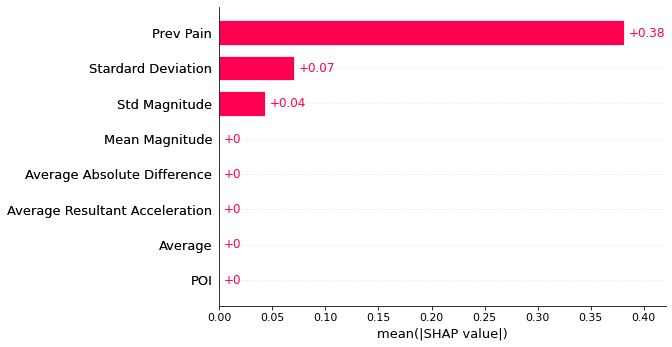

In [24]:
shap.plots.bar(shap_values)

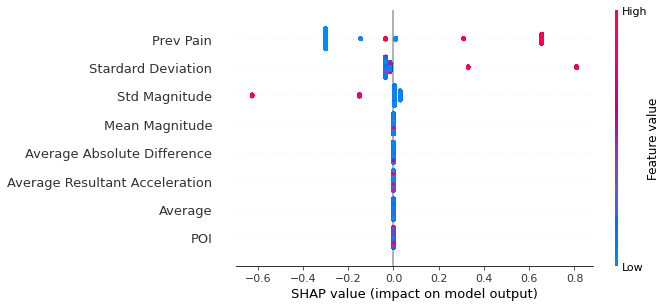

In [25]:
shap.plots.beeswarm(shap_values)

In [26]:
#shap.summary_plot(shap_values, plot_type='violin')